In [73]:
!pip install -Uq sentence-transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
panel 0.13.1 requires bokeh<2.5.0,>=2.4.0, but you have bokeh 3.3.2 which is incompatible.
spyder 5.3.3 requires ipython<8.0.0,>=7.31.1, but you have ipython 8.18.1 which is incompatible.
spyder 5.3.3 requires pylint<3.0,>=2.5.0, but you have pylint 3.0.2 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [338]:
!pip install langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.0/237.0 kB 2.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 3.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 850.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 855.5 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 590.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 625.2 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tenacity
    Found existing installation: tenacity 8.0.1
    Uninstalling tenacity-8.0.1:
      Successfully uninstalled tenacity-8.0.1
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: jsonpatch
    Found existing installation: jso

In [74]:
import boto3
import json
import os

In [60]:
bedrock = boto3.client(service_name='bedrock-runtime',
                       region_name= 'us-west-2')
smr_client = boto3.client("sagemaker-runtime")

In [61]:
BEDROCK_EMBEDDING_MODELID_LIST = ["cohere.embed-multilingual-v3","cohere.embed-english-v3","amazon.titan-embed-text-v1"]

In [62]:
def get_embedding_bedrock(texts,model_id):
    provider = model_id.split(".")[0]
    if provider == "cohere":
        body = json.dumps({
            "texts": [texts] if isinstance(texts, str) else texts,
            "input_type": "search_document"
        })
    else:
        # includes common provider == "amazon"
        body = json.dumps({
            "inputText": texts if isinstance(texts, str) else texts[0],
        })
    bedrock_resp = bedrock.invoke_model(
            body=body,
            modelId=model_id,
            accept="application/json",
            contentType="application/json"
        )
    response_body = json.loads(bedrock_resp.get('body').read())
    if provider == "cohere":
        embeddings = response_body['embeddings']
    else:
        embeddings = [response_body['embedding']]
    return embeddings

In [63]:
def get_embedding(smr_client, text_arrs, endpoint_name):
    if endpoint_name in BEDROCK_EMBEDDING_MODELID_LIST:
        return get_embedding_bedrock(text_arrs,endpoint_name)
    
        
    parameters = {
    }

    response_model = smr_client.invoke_endpoint(
                EndpointName=endpoint_name,
                Body=json.dumps(
                {
                    "inputs": text_arrs,
                    "parameters": parameters,
                    "is_query" : False,
                    "instruction" :  None
                }
                ),
                ContentType="application/json",
            )
    
    json_str = response_model['Body'].read().decode('utf8')
    json_obj = json.loads(json_str)
    embeddings = json_obj["sentence_embeddings"]
    
    return embeddings

In [11]:
import numpy as np
def cos_sim(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_v1 = np.linalg.norm(vector1)
    norm_v2 = np.linalg.norm(vector2)
    cos_sim = dot_product / (norm_v1 * norm_v2)
    return cos_sim

In [12]:
model1 = 'bge-m3-2024-02-04-08-46-45-274-endpoint'
model2 = 'cohere.embed-multilingual-v3'

In [22]:
prompts1 = ["How to compete with OCI","如何与OCI竞争","如何與OCI競爭","how to compete with Azure?","如何与Azure竞争"]
prompts2 = ["战报里的属性，其他加成都有什么？","无语了，没见过这么垃圾的玩意","回复的什么乱七八糟的","你这个系统弱智啊","你们的服务烂透了"]

In [23]:
#BGE
emb = get_embedding(smr_client,prompts1,model1)

In [24]:
[f"{i}->{j}:{cos_sim(emb[i],emb[j])}" for i in range(len(emb)) for j in range(len(emb)) if i<j]

['0->1:0.9578159281879426',
 '0->2:0.9591341398002522',
 '0->3:0.587384531840191',
 '0->4:0.5893676694480744',
 '1->2:0.9855927192713957',
 '1->3:0.654870073817726',
 '1->4:0.6771000040973838',
 '2->3:0.6409406130635309',
 '2->4:0.6616086197159503',
 '3->4:0.9335057855472207']

In [25]:
#coherer
emb = get_embedding(smr_client,prompts1,model2)

In [26]:
[f"{i}->{j}:{cos_sim(emb[i],emb[j])}" for i in range(len(emb)) for j in range(len(emb)) if i<j]

['0->1:0.8052604221203034',
 '0->2:0.8250860994168235',
 '0->3:0.76823627327943',
 '0->4:0.6520136517935383',
 '1->2:0.9519627621491288',
 '1->3:0.6575757605314292',
 '1->4:0.8483881001910436',
 '2->3:0.6611007312877046',
 '2->4:0.806612793579891',
 '3->4:0.798907155186627']

## 读取example 数据集

In [329]:
path = '../../docs/intentions'
files = [ f"{path}/{fn}" for fn in os.listdir(path) if fn != '.ipynb_checkpoints']

In [330]:
files

['../../docs/intentions/conversations.example',
 '../../docs/intentions/aws_service_status.example',
 '../../docs/intentions/comfort.example',
 '../../docs/intentions/aws_faq.example',
 '../../docs/intentions/assist.example',
 '../../docs/intentions/abbr.example',
 '../../docs/intentions/get_contact.example',
 '../../docs/intentions/aws_price.example',
 '../../docs/intentions/transfer.example']

In [57]:
data_groups = []

In [58]:
for file in files:
    with open(file,'r') as f:
        content = json.loads(f.read())
        func = content['examples'][0]['detection']['func']
        queries = [ [it['query'],func] for it in content['examples']]
        data_groups += queries

In [64]:
data_groups[:2]

[['早上好，你好吗?', 'chat'], ['你好', 'chat']]

In [68]:
inputs = [i[0] for i in data_groups]

In [337]:
import pandas as pd
pd.DataFrame(data_groups,columns=['example','intent']).sample(20)

,example,intent
43,怎么提交FOOB？,QA
49,需要提前多久申请FOOB？,QA
119,c5.xlarge的windows实例价格？,ec2_price
105,Lily 负责哪一部份？？,get_contact
64,ODCR预留怎么计费？,QA
7,蛋糕是一个谎言.,chat
79,改写得更简练，但是要适合口述演讲，不能机械化,assist
58,"in what senarios, I need FOOB?",QA
6,我在做个东西.,chat
19,今天心情有点糟,chat


## 定义评估函数

In [413]:
from sentence_transformers import util
import torch
from sklearn import metrics

In [301]:
def evaluate_topk(emb,threshold,topk=5):
    emb_t = torch.tensor(emb)
    hits = util.semantic_search(query_embeddings = emb_t, corpus_embeddings = emb_t,top_k=topk)
    testresults = [(data_groups[idx],
                data_groups[h['corpus_id']],
                h['score'], 
                0 if data_groups[idx][1] != data_groups[h['corpus_id']][1] else 1) for idx, hit in enumerate(hits) for h in hit if h['score'] > threshold]
    fault_results = [t for t in testresults if t[3] == 0]
    print(f"threshold:{threshold:.2f},Total hits:{len(hits)*topk},Total results:{len(testresults)}, recall rate:{100*len(testresults)/len(hits)/topk:.2f}%, faults:{len(fault_results)}, faults rate:{100*len(fault_results)/len(testresults):.2f}%")
    return threshold,len(testresults)/len(hits)/topk,1-len(fault_results)/len(testresults)

In [306]:
def sims_label_topk(emb,topk=5):
    emb_t = torch.tensor(emb)
    hits = util.semantic_search(query_embeddings = emb_t, corpus_embeddings = emb_t,top_k=topk)
    pred_labels = [( h['score'], 
                0 if data_groups[idx][1] != data_groups[h['corpus_id']][1] else 1) for idx, hit in enumerate(hits) for h in hit]
    return pred_labels
    

In [391]:
def view_lable_topk(inputs,emb,topk=5):
    emb_t = torch.tensor(emb)
    hits = util.semantic_search(query_embeddings = emb_t, corpus_embeddings = emb_t,top_k=topk)
    pred_labels = [( inputs[idx][0],
                inputs[h['corpus_id']][0],
        h['score'], 
                0 if data_groups[idx][1] != data_groups[h['corpus_id']][1] else 1) for idx, hit in enumerate(hits) for h in hit]
    return pred_labels
    

In [423]:
def evaluate_topk_f1(data_groups,emb,threshold,topk=5):
    emb_t = torch.tensor(emb)
    hits = util.semantic_search(query_embeddings = emb_t, corpus_embeddings = emb_t,top_k=topk)
    testresults = [(1 if h['score'] > threshold else 0,
                0 if data_groups[idx][1] != data_groups[h['corpus_id']][1] else 1) for idx, hit in enumerate(hits) for h in hit]
    y_pred = np.array([i[0] for i in testresults ] )
    y_true = np.array([i[1] for i in testresults ] )
    f1 = metrics.f1_score(y_true, y_pred)

    print(f'threshold:{threshold:3f},F1 Score:{f1:.3f}')
    
    return threshold,f1

In [286]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [311]:
# 画出在不同threshold下的recall和acc
def plot_recall_acc(results):
    df = pd.DataFrame(results,columns=['threshold','recall','acc'])
    plt.plot(df['threshold'],df['recall'],label='recall')
    plt.plot(df['threshold'],df['acc'],label='acc')
    plt.xlabel('Threshold')
    plt.ylabel('Rate')
    plt.title('Recall and Acc')
    plt.legend(loc="lower right")
    plt.show()

In [410]:
#  画出roc曲线，计算AUC
def plot_roc(pred_labels):
    y_pred = np.array([i[0] for i in pred_labels])
    y_true = np.array([i[1] for i in pred_labels])

    # 计算roc曲线
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    # 画图
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

In [420]:
def plot_f1_scores(f1_scores):
    df = pd.DataFrame(f1_scores,columns=['threshold','f1_score'])
    plt.plot(df['threshold'],df['f1_score'],label='f1_score')
    plt.xlabel('Threshold')
    plt.ylabel('f1_score')
    plt.title('f1_score')
    plt.legend(loc="lower right")
    plt.show()

In [402]:
steps = [i for i in np.arange(0.05,1,0.01)]

In [296]:
# !pip install -U seaborn matplotlib

## 使用bge

In [228]:
emb1 = get_embedding(smr_client,inputs,model1)

In [395]:
pd.DataFrame(view_lable_topk(data_groups,emb1,5),columns=['query','topkrecall','sims','label']).sample(10)

,query,topkrecall,sims,label
287,what are the use cases for FOOB?,"in what senarios, I need FOOB?",0.761557,1
508,WWSO,一个 AWS 账户可以是多个 OU 的成员吗？,0.378659,0
134,DataZone在global region GA了吗？,中国区有没有glue interactive session?,0.483757,1
389,帮我写一个PPT大纲，用于年中汇报,帮我写一段适用于sdxl生成“运动会”图片的prompt，要求效果好，用英文,0.541954,1
190,对于创建堆栈失败期间回滚的资源，我是否需要付费？,对于创建堆栈失败期间回滚的资源，我是否需要付费？,1.000000,1
183,Amazon Rekognition 支持哪些图像和视频格式？,帮我把下面的文本整理成markdown格式,0.472277,0
261,怎么看资源分配是否有risk？,怎么看现有的Capacity？,0.630450,1
102,中国区有没有glue interactive session?,中国区sagemaker有jumpstart吗,0.525679,1
559,AIML北区的BD是谁？,quicksight的GTMS是谁,0.393278,1
623,SageMaker中ml.t3.large的什么价格？,c5.xlarge在美东1的价格？,0.570443,1


In [403]:
results = []
for x in steps:
    results.append(evaluate_topk(emb1,x))

threshold:0.05,Total hits:655,Total results:655, recall rate:100.00%, faults:130, faults rate:19.85%
threshold:0.06,Total hits:655,Total results:655, recall rate:100.00%, faults:130, faults rate:19.85%
threshold:0.07,Total hits:655,Total results:655, recall rate:100.00%, faults:130, faults rate:19.85%
threshold:0.08,Total hits:655,Total results:655, recall rate:100.00%, faults:130, faults rate:19.85%
threshold:0.09,Total hits:655,Total results:655, recall rate:100.00%, faults:130, faults rate:19.85%
threshold:0.10,Total hits:655,Total results:655, recall rate:100.00%, faults:130, faults rate:19.85%
threshold:0.11,Total hits:655,Total results:655, recall rate:100.00%, faults:130, faults rate:19.85%
threshold:0.12,Total hits:655,Total results:655, recall rate:100.00%, faults:130, faults rate:19.85%
threshold:0.13,Total hits:655,Total results:655, recall rate:100.00%, faults:130, faults rate:19.85%
threshold:0.14,Total hits:655,Total results:655, recall rate:100.00%, faults:130, faults ra

### 计算f1 score

threshold:0.050000,F1 Score:0.890
threshold:0.060000,F1 Score:0.890
threshold:0.070000,F1 Score:0.890
threshold:0.080000,F1 Score:0.890
threshold:0.090000,F1 Score:0.890
threshold:0.100000,F1 Score:0.890
threshold:0.110000,F1 Score:0.890
threshold:0.120000,F1 Score:0.890
threshold:0.130000,F1 Score:0.890
threshold:0.140000,F1 Score:0.890
threshold:0.150000,F1 Score:0.890
threshold:0.160000,F1 Score:0.890
threshold:0.170000,F1 Score:0.890
threshold:0.180000,F1 Score:0.890
threshold:0.190000,F1 Score:0.890
threshold:0.200000,F1 Score:0.890
threshold:0.210000,F1 Score:0.890
threshold:0.220000,F1 Score:0.890
threshold:0.230000,F1 Score:0.890
threshold:0.240000,F1 Score:0.890
threshold:0.250000,F1 Score:0.890
threshold:0.260000,F1 Score:0.890
threshold:0.270000,F1 Score:0.890
threshold:0.280000,F1 Score:0.890
threshold:0.290000,F1 Score:0.890
threshold:0.300000,F1 Score:0.890
threshold:0.310000,F1 Score:0.890
threshold:0.320000,F1 Score:0.890
threshold:0.330000,F1 Score:0.890
threshold:0.34

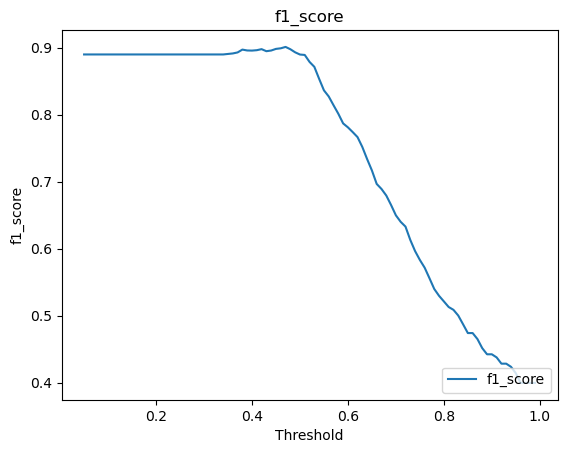

In [429]:
f1_scores = []
for x in steps:
    f1_scores.append(evaluate_topk_f1(data_groups,emb1,x))
plot_f1_scores(f1_scores)

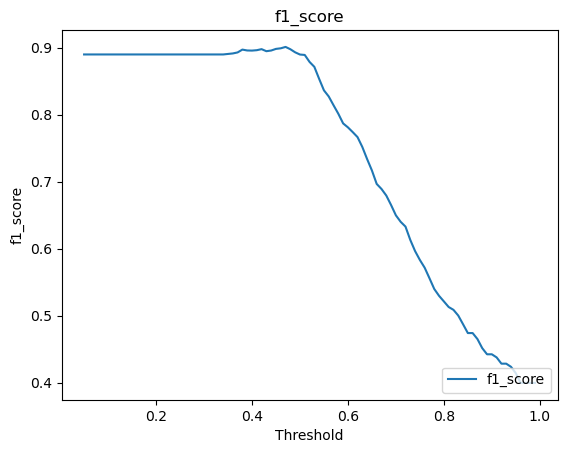

### 绘制在不同threshold下的recall和acc

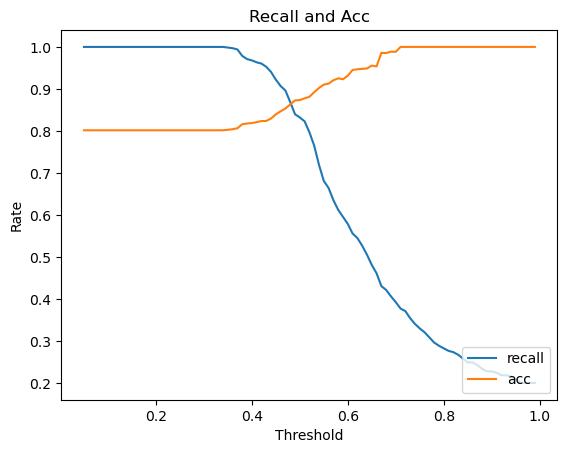

In [404]:
plot_recall_acc(results)

### 绘制ROC并计算AUC

In [408]:
pred_labels = sims_label_topk(emb1,5)

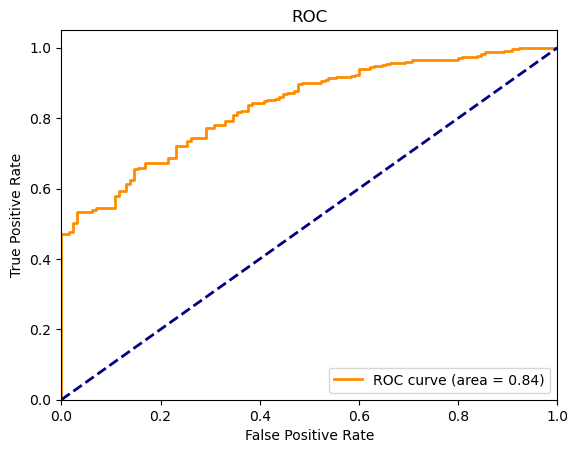

In [411]:
plot_roc(pred_labels)

## 使用cohere

In [191]:
emb2_1 = get_embedding(smr_client,inputs[:64],model2)
emb2_2 = get_embedding(smr_client,inputs[64:],model2)
emb2 = emb2_1 + emb2_2

In [427]:
results = []
for x in steps:
    results.append(evaluate_topk(emb2,x))

threshold:0.05,Total hits:655,Total results:655, recall rate:100.00%, faults:148, faults rate:22.60%
threshold:0.06,Total hits:655,Total results:655, recall rate:100.00%, faults:148, faults rate:22.60%
threshold:0.07,Total hits:655,Total results:655, recall rate:100.00%, faults:148, faults rate:22.60%
threshold:0.08,Total hits:655,Total results:655, recall rate:100.00%, faults:148, faults rate:22.60%
threshold:0.09,Total hits:655,Total results:655, recall rate:100.00%, faults:148, faults rate:22.60%
threshold:0.10,Total hits:655,Total results:655, recall rate:100.00%, faults:148, faults rate:22.60%
threshold:0.11,Total hits:655,Total results:655, recall rate:100.00%, faults:148, faults rate:22.60%
threshold:0.12,Total hits:655,Total results:655, recall rate:100.00%, faults:148, faults rate:22.60%
threshold:0.13,Total hits:655,Total results:655, recall rate:100.00%, faults:148, faults rate:22.60%
threshold:0.14,Total hits:655,Total results:655, recall rate:100.00%, faults:148, faults ra

threshold:0.050000,F1 Score:0.873
threshold:0.060000,F1 Score:0.873
threshold:0.070000,F1 Score:0.873
threshold:0.080000,F1 Score:0.873
threshold:0.090000,F1 Score:0.873
threshold:0.100000,F1 Score:0.873
threshold:0.110000,F1 Score:0.873
threshold:0.120000,F1 Score:0.873
threshold:0.130000,F1 Score:0.873
threshold:0.140000,F1 Score:0.873
threshold:0.150000,F1 Score:0.873
threshold:0.160000,F1 Score:0.873
threshold:0.170000,F1 Score:0.873
threshold:0.180000,F1 Score:0.873
threshold:0.190000,F1 Score:0.873
threshold:0.200000,F1 Score:0.873
threshold:0.210000,F1 Score:0.873
threshold:0.220000,F1 Score:0.873
threshold:0.230000,F1 Score:0.873
threshold:0.240000,F1 Score:0.873
threshold:0.250000,F1 Score:0.873
threshold:0.260000,F1 Score:0.873
threshold:0.270000,F1 Score:0.873
threshold:0.280000,F1 Score:0.873
threshold:0.290000,F1 Score:0.873
threshold:0.300000,F1 Score:0.873
threshold:0.310000,F1 Score:0.873
threshold:0.320000,F1 Score:0.873
threshold:0.330000,F1 Score:0.873
threshold:0.34

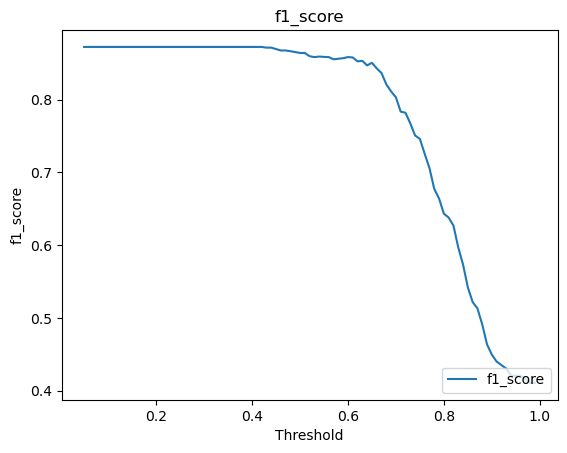

In [431]:
f1_scores = []
for x in steps:
    f1_scores.append(evaluate_topk_f1(data_groups,emb2,x))
plot_f1_scores(f1_scores)

### 绘制在不同threshold下的recall和acc

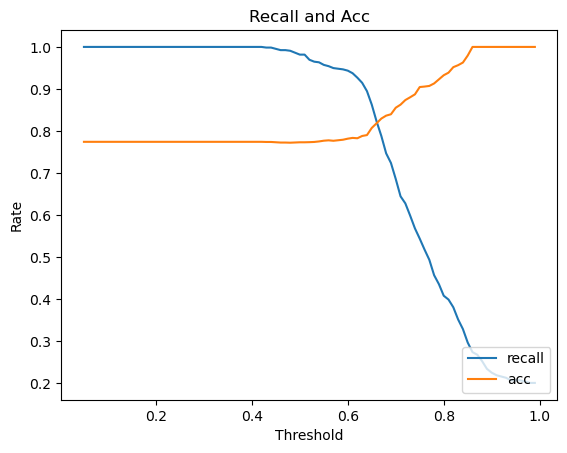

In [428]:
plot_recall_acc(results)

### 绘制ROC并计算AUC

In [319]:
pred_labels = sims_label_topk(emb2,5)

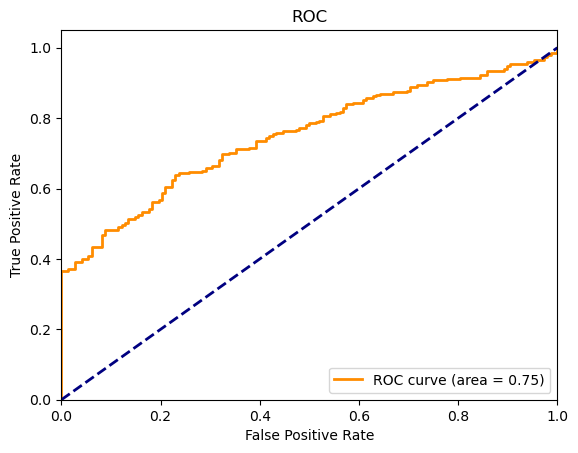

In [320]:
plot_roc(pred_labels)

## 使用Titan

In [203]:
model3 = 'amazon.titan-embed-text-v1'

emb3 = []
for text in inputs:
    emb= get_embedding(smr_client,text,model3)
    emb3 += emb

In [432]:
results = []
for x in steps:
    results.append(evaluate_topk(emb3,x))

threshold:0.05,Total hits:655,Total results:655, recall rate:100.00%, faults:155, faults rate:23.66%
threshold:0.06,Total hits:655,Total results:655, recall rate:100.00%, faults:155, faults rate:23.66%
threshold:0.07,Total hits:655,Total results:655, recall rate:100.00%, faults:155, faults rate:23.66%
threshold:0.08,Total hits:655,Total results:655, recall rate:100.00%, faults:155, faults rate:23.66%
threshold:0.09,Total hits:655,Total results:655, recall rate:100.00%, faults:155, faults rate:23.66%
threshold:0.10,Total hits:655,Total results:654, recall rate:99.85%, faults:155, faults rate:23.70%
threshold:0.11,Total hits:655,Total results:654, recall rate:99.85%, faults:155, faults rate:23.70%
threshold:0.12,Total hits:655,Total results:654, recall rate:99.85%, faults:155, faults rate:23.70%
threshold:0.13,Total hits:655,Total results:653, recall rate:99.69%, faults:155, faults rate:23.74%
threshold:0.14,Total hits:655,Total results:652, recall rate:99.54%, faults:154, faults rate:23

threshold:0.050000,F1 Score:0.866
threshold:0.060000,F1 Score:0.866
threshold:0.070000,F1 Score:0.866
threshold:0.080000,F1 Score:0.866
threshold:0.090000,F1 Score:0.866
threshold:0.100000,F1 Score:0.865
threshold:0.110000,F1 Score:0.865
threshold:0.120000,F1 Score:0.865
threshold:0.130000,F1 Score:0.864
threshold:0.140000,F1 Score:0.865
threshold:0.150000,F1 Score:0.864
threshold:0.160000,F1 Score:0.864
threshold:0.170000,F1 Score:0.863
threshold:0.180000,F1 Score:0.863
threshold:0.190000,F1 Score:0.862
threshold:0.200000,F1 Score:0.862
threshold:0.210000,F1 Score:0.862
threshold:0.220000,F1 Score:0.862
threshold:0.230000,F1 Score:0.862
threshold:0.240000,F1 Score:0.861
threshold:0.250000,F1 Score:0.862
threshold:0.260000,F1 Score:0.862
threshold:0.270000,F1 Score:0.863
threshold:0.280000,F1 Score:0.860
threshold:0.290000,F1 Score:0.859
threshold:0.300000,F1 Score:0.859
threshold:0.310000,F1 Score:0.858
threshold:0.320000,F1 Score:0.851
threshold:0.330000,F1 Score:0.850
threshold:0.34

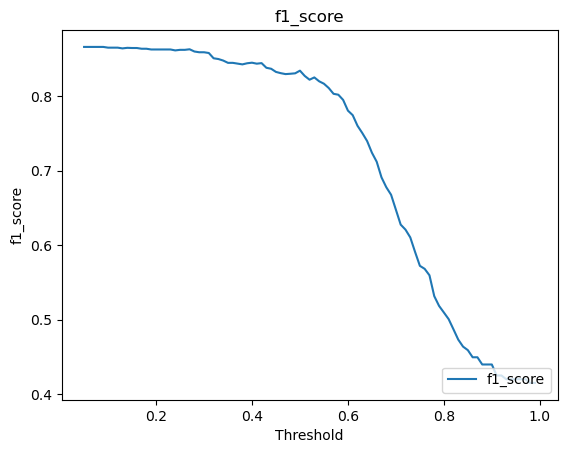

In [434]:
f1_scores = []
for x in steps:
    f1_scores.append(evaluate_topk_f1(data_groups,emb3,x))
plot_f1_scores(f1_scores)

### 绘制在不同threshold下的recall和acc

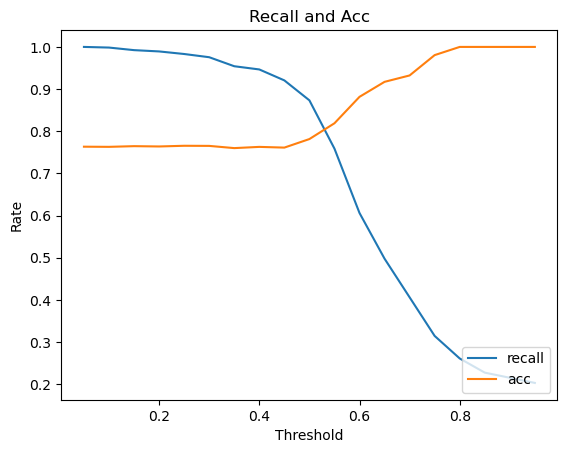

In [399]:
plot_recall_acc(results)

### 绘制ROC并计算AUC

In [400]:
pred_labels = sims_label_topk(emb3,5)

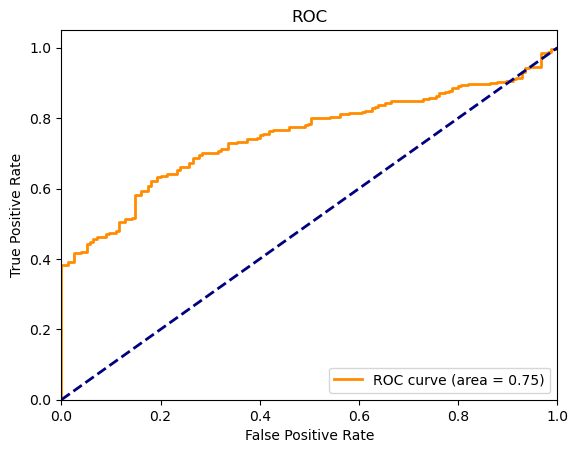

In [401]:
plot_roc(pred_labels)

## OPENAI embedding dimension 3072

In [396]:
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(openai_api_key="sk-",model='text-embedding-3-large')

In [377]:
embeddings = embeddings_model.embed_documents(inputs)

In [378]:
len(embeddings[1])

3072

In [435]:
results = []
for x in steps:
    results.append(evaluate_topk(embeddings,x))

threshold:0.05,Total hits:655,Total results:655, recall rate:100.00%, faults:116, faults rate:17.71%
threshold:0.06,Total hits:655,Total results:655, recall rate:100.00%, faults:116, faults rate:17.71%
threshold:0.07,Total hits:655,Total results:655, recall rate:100.00%, faults:116, faults rate:17.71%
threshold:0.08,Total hits:655,Total results:655, recall rate:100.00%, faults:116, faults rate:17.71%
threshold:0.09,Total hits:655,Total results:655, recall rate:100.00%, faults:116, faults rate:17.71%
threshold:0.10,Total hits:655,Total results:655, recall rate:100.00%, faults:116, faults rate:17.71%
threshold:0.11,Total hits:655,Total results:655, recall rate:100.00%, faults:116, faults rate:17.71%
threshold:0.12,Total hits:655,Total results:655, recall rate:100.00%, faults:116, faults rate:17.71%
threshold:0.13,Total hits:655,Total results:655, recall rate:100.00%, faults:116, faults rate:17.71%
threshold:0.14,Total hits:655,Total results:655, recall rate:100.00%, faults:116, faults ra

threshold:0.050000,F1 Score:0.903
threshold:0.060000,F1 Score:0.903
threshold:0.070000,F1 Score:0.903
threshold:0.080000,F1 Score:0.903
threshold:0.090000,F1 Score:0.903
threshold:0.100000,F1 Score:0.903
threshold:0.110000,F1 Score:0.903
threshold:0.120000,F1 Score:0.903
threshold:0.130000,F1 Score:0.903
threshold:0.140000,F1 Score:0.903
threshold:0.150000,F1 Score:0.903
threshold:0.160000,F1 Score:0.903
threshold:0.170000,F1 Score:0.902
threshold:0.180000,F1 Score:0.902
threshold:0.190000,F1 Score:0.903
threshold:0.200000,F1 Score:0.904
threshold:0.210000,F1 Score:0.906
threshold:0.220000,F1 Score:0.903
threshold:0.230000,F1 Score:0.903
threshold:0.240000,F1 Score:0.902
threshold:0.250000,F1 Score:0.905
threshold:0.260000,F1 Score:0.902
threshold:0.270000,F1 Score:0.900
threshold:0.280000,F1 Score:0.896
threshold:0.290000,F1 Score:0.895
threshold:0.300000,F1 Score:0.890
threshold:0.310000,F1 Score:0.880
threshold:0.320000,F1 Score:0.872
threshold:0.330000,F1 Score:0.857
threshold:0.34

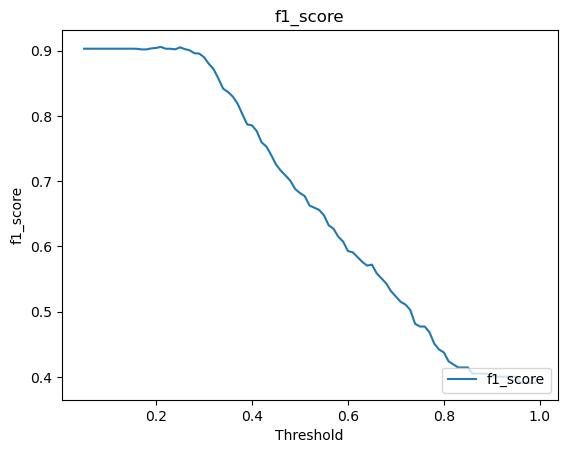

In [436]:
f1_scores = []
for x in steps:
    f1_scores.append(evaluate_topk_f1(data_groups,embeddings,x))
plot_f1_scores(f1_scores)

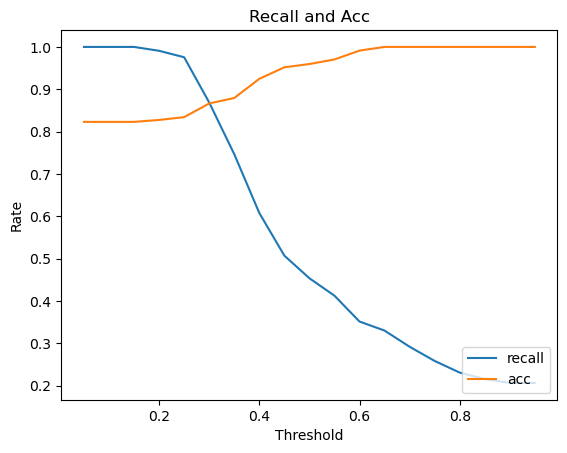

In [380]:
plot_recall_acc(results)

In [381]:
pred_labels = sims_label_topk(embeddings,5)

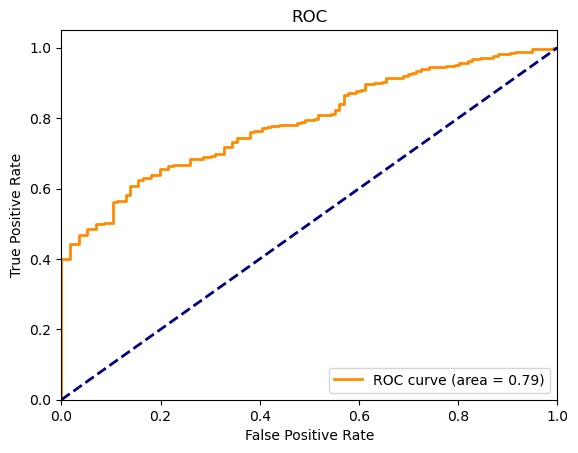

In [382]:
plot_roc(pred_labels)

In [397]:
embeddings_model2 = OpenAIEmbeddings(openai_api_key="sk-",model='text-embedding-3-large',dimensions=1536)

In [384]:
embeddings2 = embeddings_model2.embed_documents(inputs)

In [437]:
results = []
for x in steps:
    results.append(evaluate_topk(embeddings2,x))

threshold:0.05,Total hits:655,Total results:655, recall rate:100.00%, faults:119, faults rate:18.17%
threshold:0.06,Total hits:655,Total results:655, recall rate:100.00%, faults:119, faults rate:18.17%
threshold:0.07,Total hits:655,Total results:655, recall rate:100.00%, faults:119, faults rate:18.17%
threshold:0.08,Total hits:655,Total results:655, recall rate:100.00%, faults:119, faults rate:18.17%
threshold:0.09,Total hits:655,Total results:655, recall rate:100.00%, faults:119, faults rate:18.17%
threshold:0.10,Total hits:655,Total results:655, recall rate:100.00%, faults:119, faults rate:18.17%
threshold:0.11,Total hits:655,Total results:655, recall rate:100.00%, faults:119, faults rate:18.17%
threshold:0.12,Total hits:655,Total results:655, recall rate:100.00%, faults:119, faults rate:18.17%
threshold:0.13,Total hits:655,Total results:655, recall rate:100.00%, faults:119, faults rate:18.17%
threshold:0.14,Total hits:655,Total results:655, recall rate:100.00%, faults:119, faults ra

threshold:0.050000,F1 Score:0.900
threshold:0.060000,F1 Score:0.900
threshold:0.070000,F1 Score:0.900
threshold:0.080000,F1 Score:0.900
threshold:0.090000,F1 Score:0.900
threshold:0.100000,F1 Score:0.900
threshold:0.110000,F1 Score:0.900
threshold:0.120000,F1 Score:0.900
threshold:0.130000,F1 Score:0.900
threshold:0.140000,F1 Score:0.900
threshold:0.150000,F1 Score:0.900
threshold:0.160000,F1 Score:0.900
threshold:0.170000,F1 Score:0.900
threshold:0.180000,F1 Score:0.900
threshold:0.190000,F1 Score:0.898
threshold:0.200000,F1 Score:0.898
threshold:0.210000,F1 Score:0.899
threshold:0.220000,F1 Score:0.900
threshold:0.230000,F1 Score:0.898
threshold:0.240000,F1 Score:0.899
threshold:0.250000,F1 Score:0.898
threshold:0.260000,F1 Score:0.898
threshold:0.270000,F1 Score:0.900
threshold:0.280000,F1 Score:0.899
threshold:0.290000,F1 Score:0.903
threshold:0.300000,F1 Score:0.898
threshold:0.310000,F1 Score:0.897
threshold:0.320000,F1 Score:0.891
threshold:0.330000,F1 Score:0.873
threshold:0.34

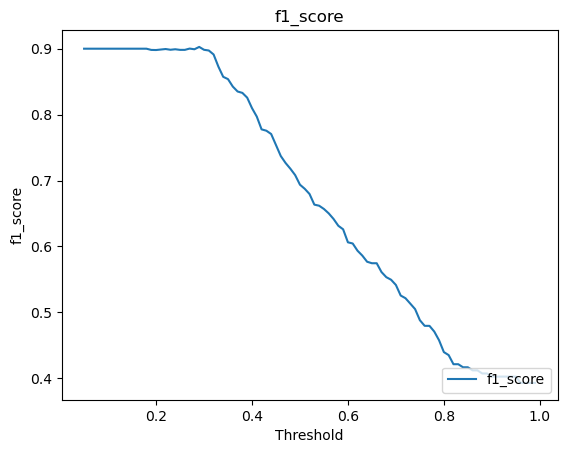

In [438]:
f1_scores = []
for x in steps:
    f1_scores.append(evaluate_topk_f1(data_groups,embeddings2,x))
plot_f1_scores(f1_scores)

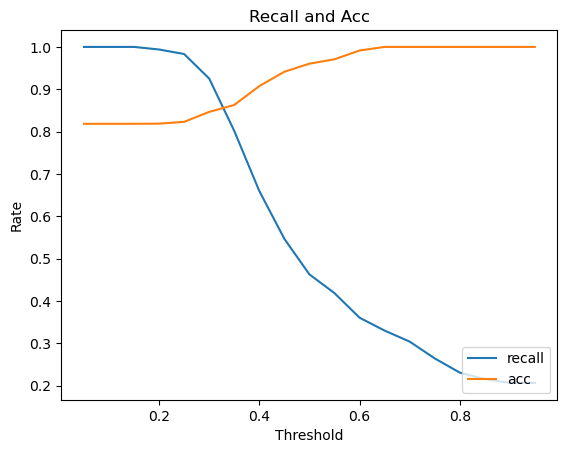

In [386]:
plot_recall_acc(results)

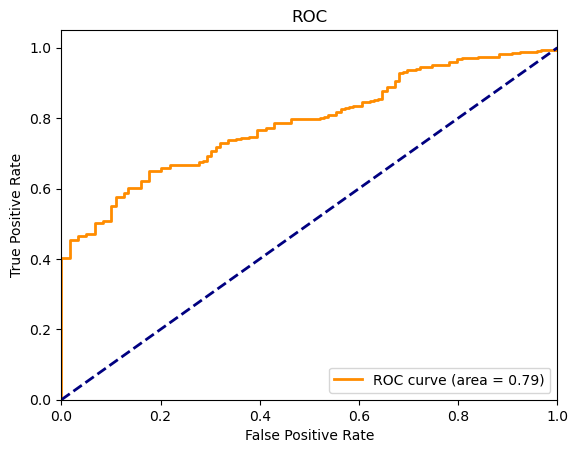

In [389]:
pred_labels = sims_label_topk(embeddings2,5)
plot_roc(pred_labels)